# 1. Denoising 101

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
import scipy.ndimage as sp

C:\Users\mikke\AppData\Local\Temp\ipykernel_4244\3149771359.py:3: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


## Denoising by filtering - from scratch

Make example image:

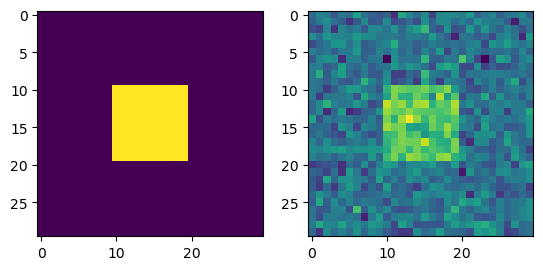

In [17]:
sz = 30
im = np.zeros((sz,sz))
im[10:20,10:20] = 1
noisy = im + np.random.normal(0, 0.3, (sz,sz))
fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(im)
fig.add_subplot(1,2,2), plt.imshow(noisy);

Make a mean convolution filter:

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
(30, 30)
(30, 30)


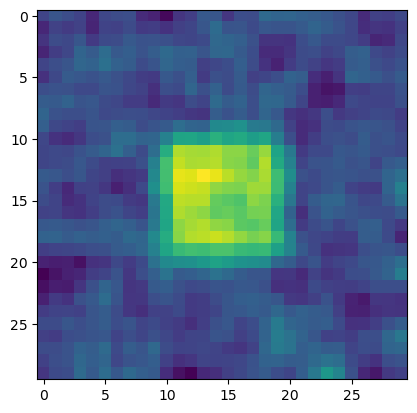

In [18]:
meanfilt = np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
print(meanfilt)
filtered = convolve(noisy, meanfilt)
plt.imshow(filtered);
print(noisy.shape)
print(filtered.shape)

Exercise: Mean filtering is most likely already implemented in a standard function. Find it (asking Professor Google) and try it ... 

Image range: -1.099299484114873 to 1.7707529046536816


C:\Users\mikke\AppData\Local\Temp\ipykernel_4244\3741558555.py:7: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  filtered = rank.mean(noisy/maxInt, disk(10))


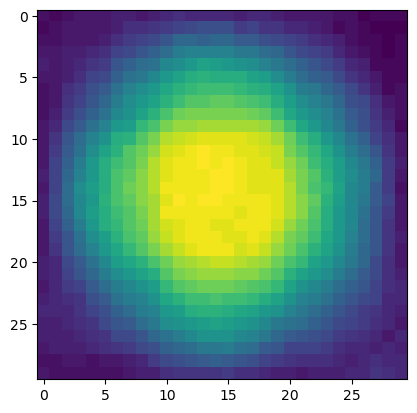

In [19]:
from skimage.morphology import disk
from skimage.filters import rank

minInt = np.min(noisy)
maxInt = np.max(noisy)
print('Image range:',minInt,'to',maxInt)
filtered = rank.mean(noisy/maxInt, disk(10))
plt.imshow(filtered)

Most often, there are standard functions doing most of the work. We have to find them and then possibly adjust our data to work with them. 

# 2. Feature Detection

## Edge Filter by convolution - from scratch

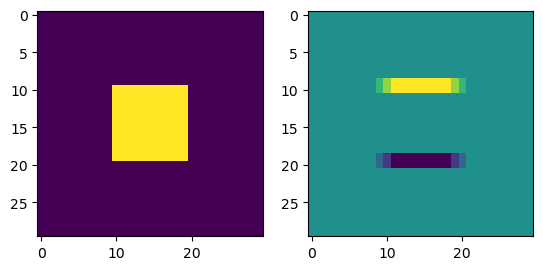

In [20]:
im = np.zeros((30,30))
im[10:20,10:20] = 1

filt = np.asarray([[1, 1, 1], 
                   [0, 0, 0], 
                   [-1, -1, -1]])
filtered = convolve(im, filt)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im)
fig.add_subplot(1,2,2)
plt.imshow(filtered);

Exercise: How do we then detect vertical edges?

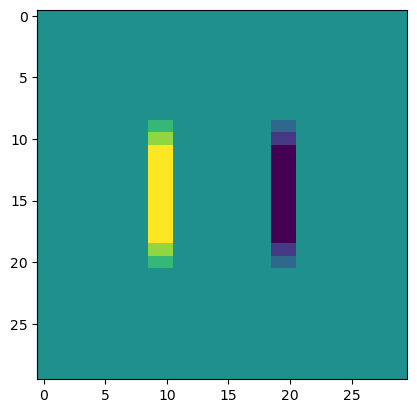

In [21]:
filtered = convolve(im, filt.T)
plt.imshow(filtered)

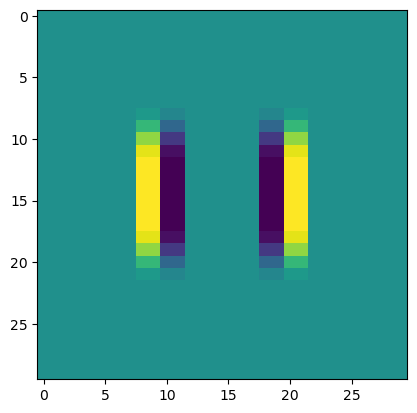

In [22]:
sobelFilt = np.asarray([[1, 0, -1], 
                          [2, 0, -2], 
                          [1, 0, -1]])
sobelFiltered = convolve(filtered, sobelFilt)
plt.imshow(sobelFiltered)

And does it work for the noisy version?

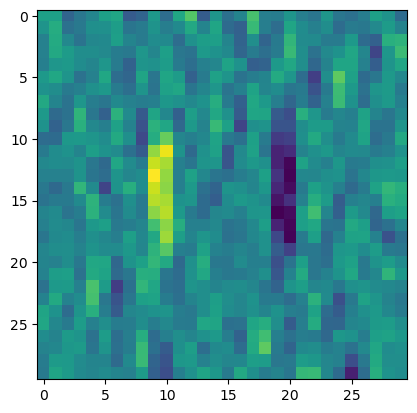

In [23]:
filtered = convolve(noisy, filt.T)
plt.imshow(filtered)

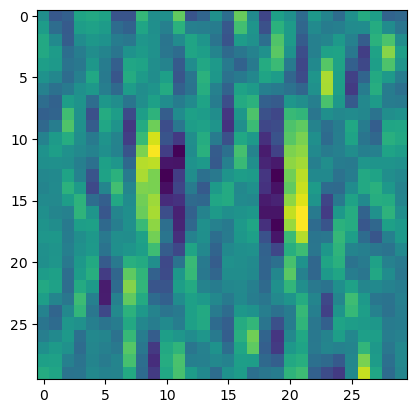

In [24]:
sobelFiltered = convolve(filtered, sobelFilt)
plt.imshow(sobelFiltered)

This edge detection is challenged a lot by moderate noise ...

## Blob filter by convolution

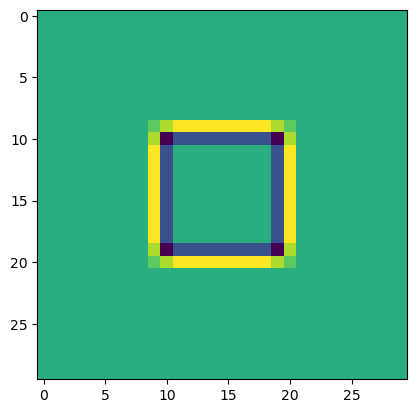

In [25]:
filt = np.asarray([[1,  1, 1], 
                   [1, -8, 1], 
                   [1,  1, 1]])
filtered = convolve(im, filt)
plt.imshow(filtered);

This was not really what we wanted .... why?

## Gaussian Derivatives

In Math, we may locally approximate a function by the Taylor series expansion, including derivatives up a given order.
Images as not continuous, even less smooth. 
So we we use Gaussian derivatives: Ix = d(I) is performed as d(G * I) = I * d(G). 
Let's do this step by step ...

First, we use the gaussian_filter function that makes the Gaussian (derivative) filter and applies it to a given image: 

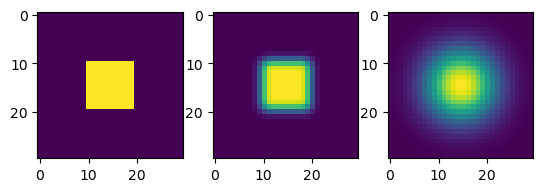

In [26]:
fig = plt.figure()
fig.add_subplot(1,3,1), plt.imshow(im)
fig.add_subplot(1,3,2), plt.imshow(sp.gaussian_filter(im, 1))
fig.add_subplot(1,3,3), plt.imshow(sp.gaussian_filter(im, 4));

The Gaussian filter blurs the image by convolution with a Gaussian kernel - at a given scale. Small scale gives narrow filter and limited blurring - large scale gives more blurring. We can use this blurring as an alternative to the denoising filter used above:

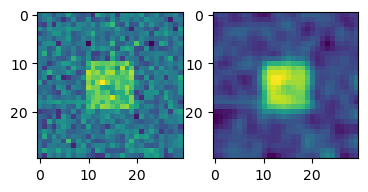

In [27]:
fig = plt.figure()
fig.add_subplot(1,3,1), plt.imshow(noisy)
fig.add_subplot(1,3,2), plt.imshow(sp.gaussian_filter(noisy, 1));

Next, if we convolve with a derivative of the Gaussian, we get a mathematically well-defined derivative. 

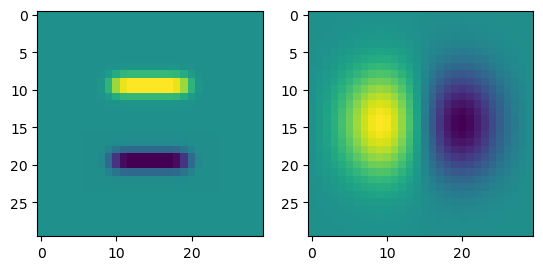

In [28]:
fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(sp.gaussian_filter(im, 1, (1,0)))
fig.add_subplot(1,2,2), plt.imshow(sp.gaussian_filter(im, 4, (0,1)));

By choosing the scale appropriately, we can look for features with small/large extent. 

Exercise: How do we find edges, invariant to the direction?

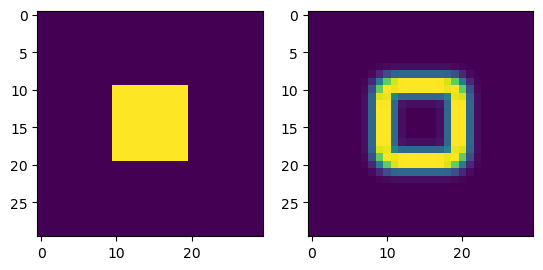

In [29]:
Ix = sp.gaussian_filter(im, 1, (1,0))
Iy = sp.gaussian_filter(im, 1, (0,1))
grad = [Ix, Iy]
gradMag = np.sqrt(Ix**2 + Iy**2)
fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(im)
fig.add_subplot(1,2,2), plt.imshow(gradMag);